In [1]:
%load_ext autoreload
%autoreload 2

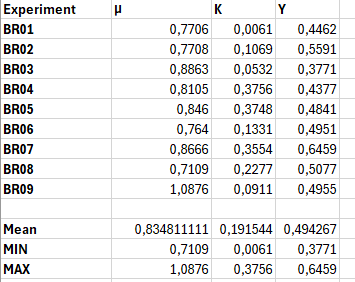

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from utils import get_data, ode_func, solve_ode
import torch
from PINN import PINN
from sklearn.preprocessing import MinMaxScaler

PATH = './data/'

def ode_func(y, t):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (S + Km)
    dydt = [mu * X, -1 / Y_XS * mu * X]
    return dydt

In [33]:
mu_max = 0.84
Km = 0.013
Y_XS = 0.501

print(f"mu_max = {mu_max:.4f}")
print(f"Km = {Km:.4f}")
print(f"Y_XS = {Y_XS:.4f}")

mu_max = 0.8400
Km = 0.0130
Y_XS = 0.5010


In [43]:
t0 = 0
t1 = df['Time'].iloc[1]
print(df[['Time', 'Glucose', 'Biomass']])

sol = odeint(ode_func, y_0, [t0, t1])
sol[-1]

       Time Glucose   Biomass
1         0    8.15     0.274
2  1.133333    6.78  0.696667
3      1.95    7.08     1.346
4      2.95    1.93  3.026136


array([0.7087758 , 7.28218404])

In [25]:
for exp_id in ["BR01", "BR02", "BR03", "BR04", "BR05", "BR06", "BR07", "BR08", "BR09"]:
    df = get_data(exp_id=exp_id, batch=True)
    
    t_start = df['Time'].values[0]
    t_end = df['Time'].values[-1]   
    y_0 = [df['Biomass'].values[0], df['Glucose'].values[0]]

    # # Solve ODE
    # t_span = [t_start, t_end]
    # t_eval = df['Time'].values
    # sol = solve_ode(mu_max, Km, Y_XS, t_start, t_end, y_0, 1000)

    # # Plot solution
    # plt.figure(figsize=(10, 3))
    # plt.plot(sol.t, sol.y[0], label='Biomass (ODE)')
    # plt.plot(sol.t, sol.y[1], label='Glucose (ODE)')
    # plt.plot(df['Time'], df['Biomass'], 'o', label='Biomass (Data)')
    # plt.plot(df['Time'], df['Glucose'], 'o', label='Glucose (Data)')
    # plt.xlabel('Time (h)')
    # plt.ylabel('Concentration (g/L)')
    # plt.title(f'Experiment {exp_id}')

